In [ ]:
# code inspired from: https://www.learnpytorch.io/

In [1]:
!unzip -q archive.zip  # after uploading "archive.zip" to colab, unzip it

In [2]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time

### Constants

In [3]:
DATASET_PATH = "Alzheimer_s Dataset"
DATASET_TRAIN_PATH = os.path.join(DATASET_PATH, "train")
DATASET_TEST_PATH = os.path.join(DATASET_PATH, "test")

BATCH_SIZE = 32
NR_EPOCHS = 75
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
DEVICE

device(type='cuda')

### Dataset

In [5]:
id2string = {0: 'NonDemented', 1: 'VeryMildDemented', 2: 'MildDemented', 3: 'ModerateDemented'}
string2id = {'NonDemented': 0, 'VeryMildDemented': 1, 'MildDemented': 2, 'ModerateDemented': 3}

In [6]:
class AlzheimerDataset(Dataset):
    def __init__(self, path, classes):
        self.images_paths = glob.glob(os.path.join(os.path.join(path, "**"), "*.jpg"), recursive=True)
        self.images_paths = random.sample(self.images_paths, len(self.images_paths))
        self.labels = [os.path.basename(os.path.dirname(p)) for p in self.images_paths]
    
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, index):
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (-1, 0, 1))
        image = image / 255.
        image = torch.tensor(image, dtype=torch.float)
        label = self.labels[index]
        label = string2id[label]
        return {"image": image, "label": label}

In [7]:
train_ds = AlzheimerDataset(path=DATASET_TRAIN_PATH, classes=string2id.keys())
test_ds = AlzheimerDataset(path=DATASET_TEST_PATH, classes=string2id.keys())

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

### Let's print how many samples we have in train/test and in each class

In [9]:
print(f"Number of train samples: {len(train_ds)}")
print(f"Number of test samples: {len(test_ds)}")
print('-' * 40)

for c in string2id.keys():
    print(f"Number of {c} samples: {len([label for label in train_ds.labels + test_ds.labels if label == c])}")

Number of train samples: 5121
Number of test samples: 1279
----------------------------------------
Number of NonDemented samples: 3200
Number of VeryMildDemented samples: 2240
Number of MildDemented samples: 896
Number of ModerateDemented samples: 64


In [10]:
# We can see above that the dataset is not balanced at all

### Let's visualize a few examples from the train set

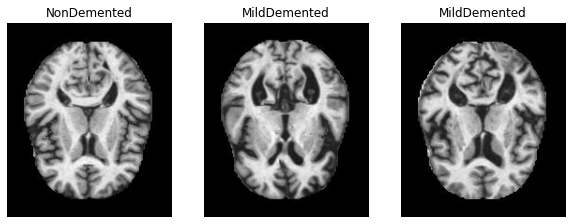

In [11]:
plt.figure(figsize=(10, 25))

plt.subplot(1, 3, 1)
a = train_ds[random.randint(0, len(train_ds) - 1)]  # choose a random train example
plt.imshow(np.transpose(a["image"], (1, 2, 0)))
plt.title(id2string[a["label"]])
plt.axis('off')

plt.subplot(1, 3, 2)
a = train_ds[random.randint(0, len(train_ds) - 1)]  # choose a random train example
plt.imshow(np.transpose(a["image"], (1, 2, 0)))
plt.title(id2string[a["label"]])
plt.axis('off')

plt.subplot(1, 3, 3)
a = train_ds[random.randint(0, len(train_ds) - 1)]  # choose a random train example
plt.imshow(np.transpose(a["image"], (1, 2, 0)))
plt.title(id2string[a["label"]])
plt.axis('off')

plt.show()

In [12]:
train_ds[random.randint(0, len(train_ds) - 1)]["image"].shape  # all the images in the dataset have the same shape

torch.Size([3, 208, 176])

### Model

In [13]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # input shape: (N, 3, 208, 176)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            # now shape is: (N, 64, 208, 176)
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            # now shape is: (N, 64, 104, 88)
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            # now shape is: (N, 128, 104, 88)
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            # now shape is: (N, 128, 52, 44)
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            # now shape is: (N, 256, 52, 44)
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            # now shape is: (N, 256, 26, 22)
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            # now shape is: (N, 512, 26, 22)
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            # now shape is: (N, 512, 13, 11)
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            # now shape is: (N, 1024, 13, 11)
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            # now shape is: (N, 1024, 6, 5)
            
            nn.Flatten(),
            # now shape is: (N, 30720)
            
            nn.Linear(in_features=30720, out_features=2048),
            # now shape is: (N, 2048)
            
            nn.Linear(in_features=2048, out_features=1024),
            # now shape is: (N, 1024)
            
            nn.Linear(in_features=1024, out_features=num_classes)
            # now shape is: (N, num_classes)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

### Test shapes

In [14]:
dummy_model = ConvNet().to(DEVICE)
dummy_input = torch.randn(32, 3, 208, 176).to(DEVICE)
dummy_output = dummy_model(dummy_input)
assert dummy_output.shape == torch.Size([32, 4])
del dummy_model

### Training loop

In [15]:
model = ConvNet()  # initialize the model
model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()  # set up the loss function
optimizer = torch.optim.Adam(params=model.parameters())  # SGD as optimizer

In [16]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [17]:
start_time = time.time()

train_loss_per_epoch = []
test_loss_per_epoch = []
test_accuracy_per_epoch = []
best_accuracy = 0
best_model = copy.deepcopy(model)

for epoch in tqdm(range(NR_EPOCHS)):
    print(f"Epoch: {epoch + 1}")
    print('-' * 7)
    train_loss = 0
    
    for batch_num, batch in enumerate(train_dl):
        X = batch["image"].to(DEVICE)
        y = batch["label"].to(DEVICE)
        
        model.train()
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if not batch_num % 45:
            print(f"Looked at {min(batch_num * BATCH_SIZE, len(train_dl.dataset))}/{len(train_dl.dataset)} samples")
    print(f"Looked at {len(train_dl.dataset)}/{len(train_dl.dataset)} samples")

    train_loss /= len(train_dl)
    
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch in test_dl:
            X = batch["image"].to(DEVICE)
            y = batch["label"].to(DEVICE)
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
            
        test_loss /= len(test_dl)
        test_acc /= len(test_dl)
    
    if test_acc > best_accuracy:
      best_accuracy = test_acc
      best_model = copy.deepcopy(model)
    
    train_loss_per_epoch.append(train_loss.detach().to("cpu").item())
    test_loss_per_epoch.append(test_loss.detach().to("cpu").item())
    test_accuracy_per_epoch.append(test_acc)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")
    print(f"Time elapsed: {(time.time() - start_time):.2f}")

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1
-------
Looked at 0/5121 samples
Looked at 1440/5121 samples
Looked at 2880/5121 samples
Looked at 4320/5121 samples
Looked at 5121/5121 samples

Train loss: 11.94492 | Test loss: 0.98244, Test accuracy: 55.04%
Time elapsed: 27.67
Epoch: 2
-------
Looked at 0/5121 samples
Looked at 1440/5121 samples
Looked at 2880/5121 samples
Looked at 4320/5121 samples
Looked at 5121/5121 samples

Train loss: 0.93806 | Test loss: 1.26949, Test accuracy: 51.28%
Time elapsed: 54.84
Epoch: 3
-------
Looked at 0/5121 samples
Looked at 1440/5121 samples
Looked at 2880/5121 samples
Looked at 4320/5121 samples
Looked at 5121/5121 samples

Train loss: 0.92131 | Test loss: 0.89200, Test accuracy: 58.40%
Time elapsed: 82.19
Epoch: 4
-------
Looked at 0/5121 samples
Looked at 1440/5121 samples
Looked at 2880/5121 samples
Looked at 4320/5121 samples
Looked at 5121/5121 samples

Train loss: 0.88021 | Test loss: 0.85277, Test accuracy: 56.28%
Time elapsed: 109.68
Epoch: 5
-------
Looked at 0/5121 samples


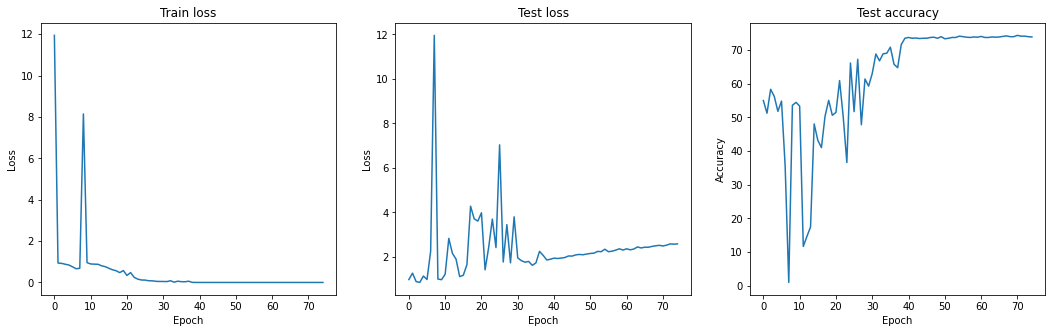

In [18]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(NR_EPOCHS), train_loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train loss")

plt.subplot(1, 3, 2)
plt.plot(range(NR_EPOCHS), test_loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test loss")

plt.subplot(1, 3, 3)
plt.plot(range(NR_EPOCHS), test_accuracy_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test accuracy")

plt.show()

###(OPTIONAL) Save the best model to disk

In [19]:
torch.save(best_model.state_dict(), "best_model.pth")

###(OPTIONAL) Load the model from memory

In [ ]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load("best_model.pth"))